In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from PIL import Image
import geopandas as gpd
from matplotlib import pyplot as plt
from geopy import distance
%matplotlib inline

# Основне завдання

## 1. Подивитись, проаналізувати структуру

In [2]:
df = pd.read_csv('../data/Data2.csv', sep=';', encoding="ISO-8859-1")
df.head()

,Country Name,Region,GDP per capita,Populatiion,CO2 emission,Area
0,Afghanistan,South Asia,"561,7787463",34656032.0,"9809,225",652860
1,Albania,Europe & Central Asia,"4124,98239",2876101.0,"5716,853",28750
2,Algeria,Middle East & North Africa,"3916,881571",40606052.0,"145400,217",2381740
3,American Samoa,East Asia & Pacific,"11834,74523",55599.0,NaN,200
4,Andorra,Europe & Central Asia,"36988,62203",77281.0,"462,042",470


In [3]:
df.tail()

,Country Name,Region,GDP per capita,Populatiion,CO2 emission,Area
212,Virgin Islands (U.S.),Latin America & Caribbean,NaN,102951.0,NaN,350
213,West Bank and Gaza,Middle East & North Africa,"2943,404534",4551566.0,NaN,6020
214,"Yemen, Rep.",Middle East & North Africa,"990,334774",27584213.0,"22698,73",527970
215,Zambia,Sub-Saharan Africa,"1269,573537",16591390.0,"4503,076",752610
216,Zimbabwe,Sub-Saharan Africa,"1029,076649",16150362.0,"12020,426",390760


### У даному датасеті присутні пропущені значення (NaN), дублікати відсутні, наявні від’ємні значення, типи даних стовпців з числовими значеннями не є числовими, замість крапки використана кома для розділення дробової частини числа, назви країн мають зайві частини.Таким чином, треба виконати виправлення помилок у даних та відформатовано їх (аналогічно до 3 лабораторної роботи).

In [4]:
df = df.rename(columns={'Populatiion': 'Population'})
for column in ['GDP per capita', 'CO2 emission', 'Area']:
    df[column] = df[column].str.replace(',', '.')
    df[column] = df[column].str.replace('-', '')
    df[column] = df[column].astype(float)
country_mapping = {'Congo, Dem. Rep.': 'Democratic Republic of the Congo', 'Congo, Rep.': 'Republic of the Congo'}
df['Country Name'] = df['Country Name'].replace(country_mapping)
df['Country Name'] = df['Country Name'].str.extract(r'([a-zA-Z\s\.]+)')
df.fillna(df.mean(numeric_only=True), inplace=True)
df['Population'] = df['Population'].astype('int')
df.head()

,Country Name,Region,GDP per capita,Population,CO2 emission,Area
0,Afghanistan,South Asia,561.778746,34656032,9809.225000,652860.0
1,Albania,Europe & Central Asia,4124.982390,2876101,5716.853000,28750.0
2,Algeria,Middle East & North Africa,3916.881571,40606052,145400.217000,2381740.0
3,American Samoa,East Asia & Pacific,11834.745230,55599,165114.116337,200.0
4,Andorra,Europe & Central Asia,36988.622030,77281,462.042000,470.0


In [5]:
df.dtypes

Country Name       object
Region             object
GDP per capita    float64
Population          int64
CO2 emission      float64
Area              float64
dtype: object

## 2. Вказати, чи є параметри, що розподілені за нормальним законом


### 2.1 Використання тесту Д'Агостіно та Пірсона, який поєднує асиметрію та ексцес для отримання комплексного тесту на нормальність, з рівнем значущості 0.05

In [6]:
def test_normal_distribution(column, alpha=0.05):
    _, p = stats.normaltest(column)
    return pd.Series({'is_normal': alpha < p, 'p_value': p})


df.select_dtypes(include='number').apply(test_normal_distribution)

,GDP per capita,Population,CO2 emission,Area
is_normal,False,False,False,False
p_value,0.0,0.0,0.0,0.0


### Оскільки отримані значення ймовірності (p_value) для усіх параметрів є меншими за встановлений рівень значущості (0.05), то гіпотези про їхній нормальний розподіл відхилені.

### 2.2 Гістограми для усіх числових стовпців

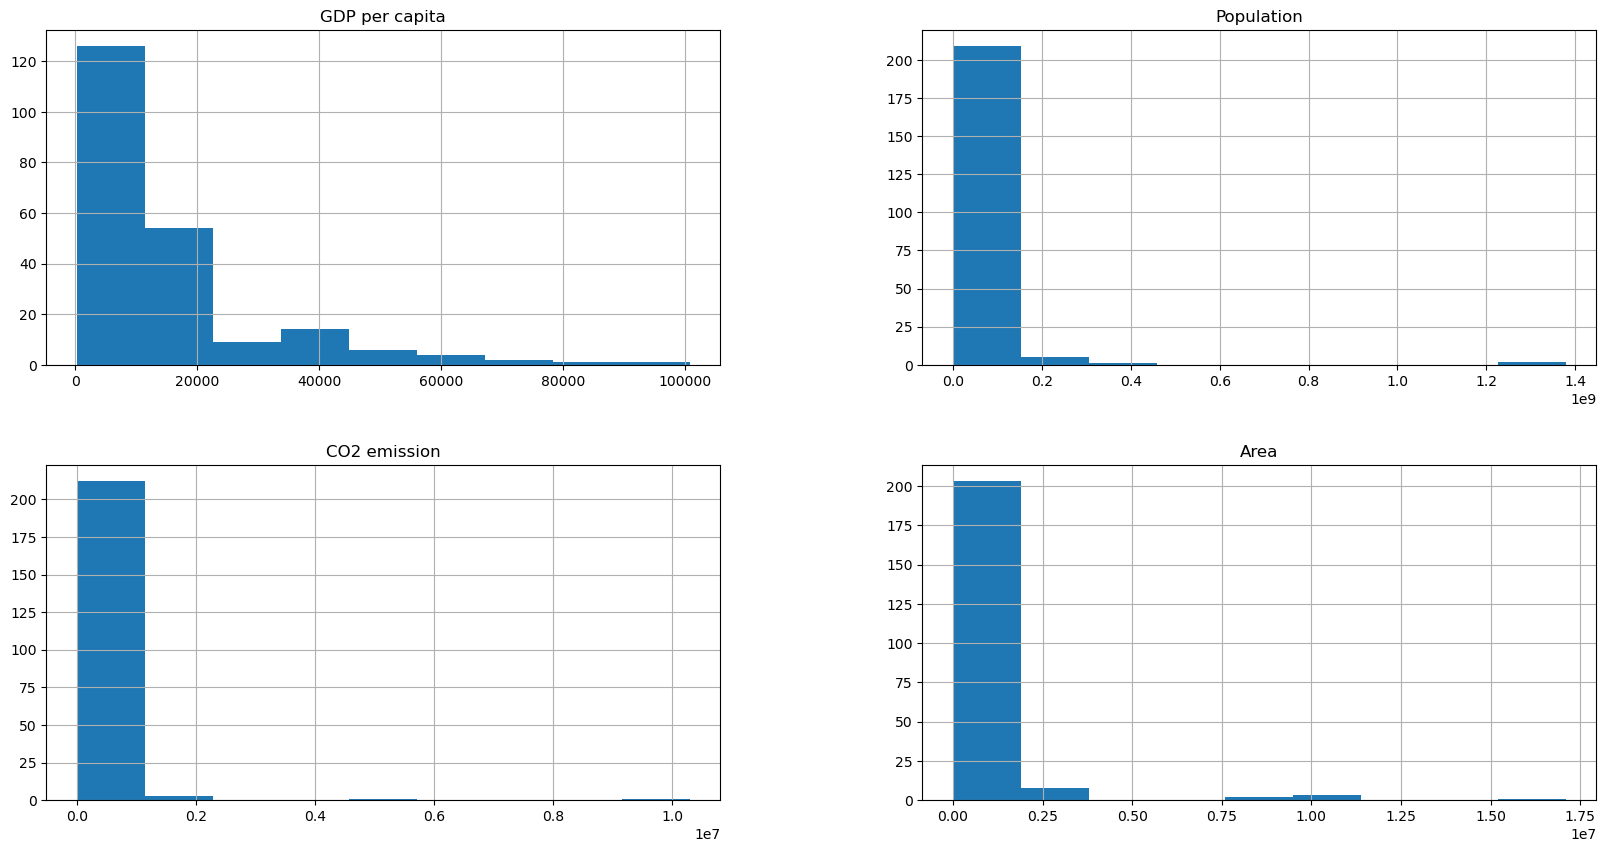

In [7]:
df.hist(figsize=(20, 10), bins=9);

### З гістограм видно, що навряд хоча б якісь параметри розподілені за нормальним законом.

## 3. Перевірити гіпотезу про рівність середнього і медіани для одного з параметрів


### 3.1 Перевірка даної гіпотези (для параметра GDP per capita) за допомогою одновибіркового t-критерію Стьюдента з рівнем значущості 0.05

In [8]:
def t_test(column, alpha=0.05):
    _, p_value = stats.ttest_1samp(column, column.median())
    return pd.Series({'is_equal': alpha < p_value, 'p_value': p_value}, name=column.name)


t_test(df['GDP per capita'])

is_equal    False
p_value       0.0
Name: GDP per capita, dtype: object

### Оскільки отримане значення ймовірності (p_value) для параметру GDP per capita є меншими за встановлений рівень значущості (0.05), то гіпотеза про рівність його середнього та медіани відхилена.

## 4. Вказати, в якому регіоні розподіл викидів СО2 найбільш близький до нормального


### 4.1 Групування по регіонам та використання  критерія узгодженості Андерсона-Дарлінга та виведення регіона з найменшою мінімальною різницею по модулю між обчисленою статистикою та критичними значеннями для різних рівнів значущості

In [9]:
def get_difference(series):
    statistic, critical_values, _ = stats.anderson(series)
    return np.abs(statistic - critical_values).min()


differences_df = df.groupby('Region')['CO2 emission'].aggregate(get_difference).rename('Difference')
differences_df[[differences_df.idxmin()]]

Region
South Asia    1.100605
Name: Difference, dtype: float64

### Таким чином, згідно критерію Андерсона-Дарлінга у Південній Азії розподіл викидів СО2 найбільш близький до нормального.

## 5. Побудувати кругову діаграму населення по регіонам

### 5.1 Групування по регіонам, використання суми значень кількості населення в якості функції агрегації та використання методу pie() для побудови кругової діаграми

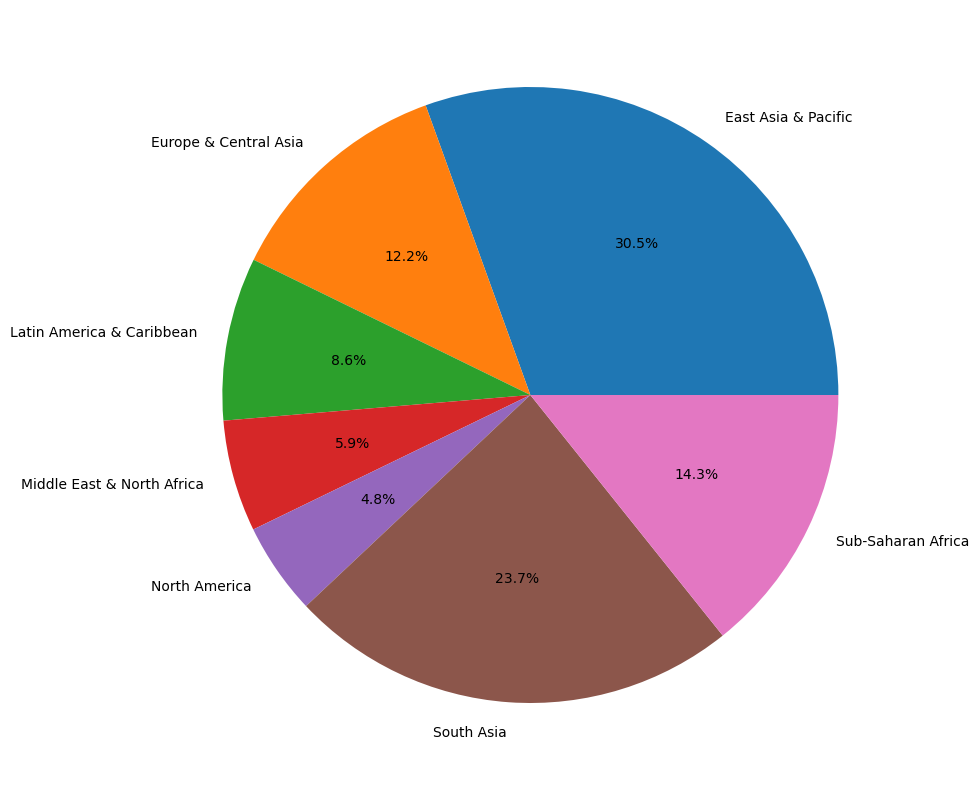

In [10]:
df.groupby('Region')['Population'].sum().plot.pie(ylabel='', autopct='%1.1f%%', figsize=(10, 10));

# Додаткове завдання

## Завдання 1

### 1. Завантажити карту України  Ukraine.jpg

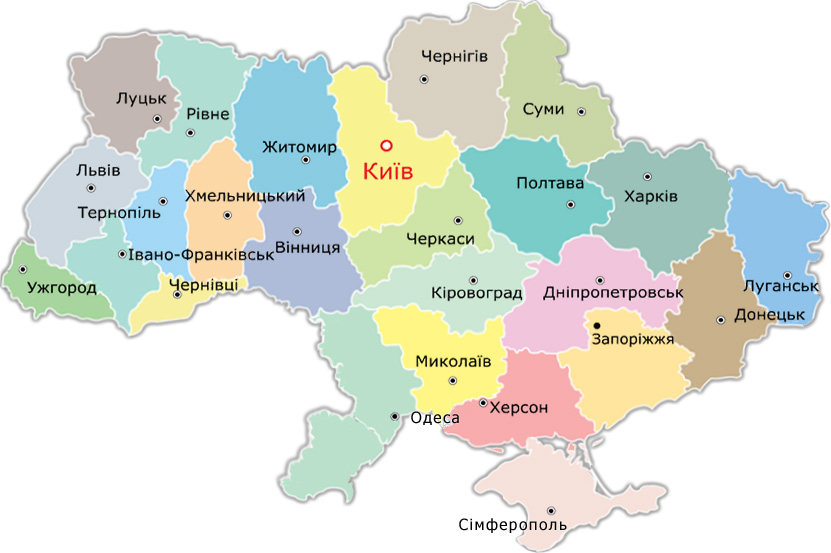

In [11]:
ukraine_map = Image.open('../data/Ukraine.jpg')
ukraine_map

### 2. Розмістити бульбашки, що відповідають їх населенню, на довільних 5 містах (статистику взяти в інтернеті)


#### 2.1 Завнтаження csv-файлу, що містить кількість населення, широту та довготу деяких міст України, а також "виправлену" широту та довготу (які відповідають завантаженій карті)

In [12]:
population_df = pd.read_csv('../data/cities_population.csv')
population_df

,city,population,latitude,longitude,map_latitude,map_longitude
0,Вінниця,1507738,49.2167,28.4333,49.06,28.6100
1,Луцьк,1020770,50.7478,25.3244,50.69,25.5200
2,Дніпр,3093151,48.4675,35.0400,48.32,35.2100
3,Донецьк,4056405,48.0089,37.8042,47.76,37.8300
4,Житомир,1177564,50.2544,28.6578,50.07,28.8200
5,Ужгород,1243721,48.6239,22.2950,48.48,22.6300
6,Запоріжжя,1636322,47.8378,35.1383,47.70,35.1200
7,Івано-Франківськ,1350565,48.9228,24.7106,48.73,24.7900
8,Київ,4746244,50.4500,30.5236,50.28,30.5700
9,Кропивницький,902275,48.5103,32.2667,48.36,32.4100


#### 2.2 Створення GeoDataFrame зі стовпцем geometry, що містить точки з координатами на карті, за допомогою бібліотеки geopandas та стовпця bubble_size, що містить розміри бульбашок (маркерів) відповідно до кількості населення

In [13]:
population_df = gpd.GeoDataFrame(population_df,
                                 geometry=gpd.points_from_xy(population_df['map_longitude'], population_df['map_latitude']))
population_df.drop(columns=['map_latitude', 'map_longitude'], inplace=True)
population_df['population'] = population_df['population'] / 1000
population_df['bubble_size'] = population_df['population'] / 4
population_df['geometry'] = population_df['geometry']
population_df.head()

,city,population,latitude,longitude,geometry,bubble_size
0,Вінниця,1507.738,49.2167,28.4333,POINT (28.61000 49.06000),376.93450
1,Луцьк,1020.770,50.7478,25.3244,POINT (25.52000 50.69000),255.19250
2,Дніпр,3093.151,48.4675,35.0400,POINT (35.21000 48.32000),773.28775
3,Донецьк,4056.405,48.0089,37.8042,POINT (37.83000 47.76000),1014.10125
4,Житомир,1177.564,50.2544,28.6578,POINT (28.82000 50.07000),294.39100


#### 2.3 Розміщення бульбашок, що відповідають кільості населення міста, для першим 5 міст з датафрейму на карті України з легендою, розташованою праворуч

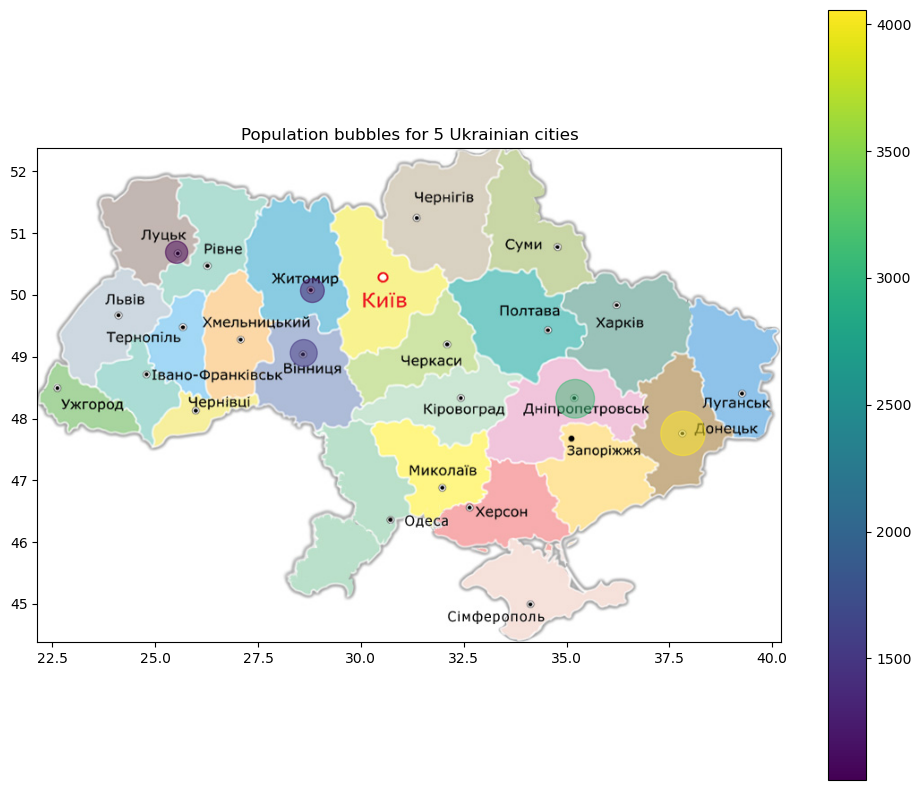

In [14]:
ukraine_map_array = np.array(ukraine_map)
min_longitude, max_longitude = 22.1371, 40.2252
min_latitude, max_latitude = 44.3820, 52.3795

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Population bubbles for 5 Ukrainian cities')
population_df.head().plot(ax=ax, column='population', markersize='bubble_size', alpha=0.5, categorical=False,
                          legend=True)
ax.imshow(ukraine_map_array, extent=[min_longitude, max_longitude, min_latitude, max_latitude],
          aspect=ukraine_map.width / ukraine_map.height);

### 3. Знайти найбільшу відстань між містами в пікселях та кілометрах

#### 3.1 Знаходження відстаней для кожної унікальної пари міст в кілометрах за допомогою функції distance бібліотеки geopy та в пікселях шляхом множення різниці широт на кількість піскеселів в одному градусі (аналогічно для довготи) та знаходження довжини вектора (шуканої відстані) по отриманим кількостям пікселей широти та довготи в якості його координат

In [15]:
cities_origin = []
cities_destination = []
distances_km = []
distances_pixels = []

pixel_latitude = ukraine_map.height / (max_latitude - min_latitude)
pixel_longitude = ukraine_map.width / (max_longitude - min_longitude)
for i, row_1 in population_df.iterrows():
    city_1 = row_1['city']
    latitude_1 = row_1['latitude']
    longitude_1 = row_1['longitude']
    for _, row_2 in population_df.iloc[i + 1:, :].iterrows():
        cities_origin.append(city_1)
        city_2 = row_2['city']
        cities_destination.append(city_2)
        latitude_2 = row_2['latitude']
        longitude_2 = row_2['longitude']
        distances_km.append(distance.distance((latitude_1, longitude_1), (latitude_2, longitude_2)).km)
        latitude_pixels = (latitude_2 - latitude_1) * pixel_latitude
        longitude_pixels = (longitude_2 - longitude_1) * pixel_longitude
        distances_pixels.append(np.linalg.norm([latitude_pixels, longitude_pixels]))

distances_df = pd.DataFrame({
    'city_1': cities_origin,
    'city_2': cities_destination,
    'distance_km': distances_km,
    'distance_pixels': distances_pixels
})
distances_df

,city_1,city_2,distance_km,distance_pixels
0,Вінниця,Луцьк,280.533189,177.787827
1,Вінниця,Дніпр,491.888351,307.912941
2,Вінниця,Донецьк,703.429965,438.541783
3,Вінниця,Житомир,116.546067,72.490915
4,Вінниця,Ужгород,454.540451,284.968034
...,...,...,...,...
320,Хмельницький,Чернівці,147.928334,92.158509
321,Хмельницький,Чернігів,382.301946,243.914393
322,Черкаси,Чернівці,467.186114,292.494368
323,Черкаси,Чернігів,234.358733,146.008980


#### 3.2 Виведення найбільшої відстані між містами в кілометрах та найбільшої відстані в пікселях

In [16]:
distances_df.iloc[[distances_df['distance_km'].idxmax()]]

,city_1,city_2,distance_km,distance_pixels
119,Ужгород,Луганськ,1253.980553,782.775325


In [17]:
distances_df.iloc[[distances_df['distance_pixels'].idxmax()]]

,city_1,city_2,distance_km,distance_pixels
119,Ужгород,Луганськ,1253.980553,782.775325


#### Отже, що в пікселях, що в кілометрах набйбільша відстань - між Ужгородом та Луганськом.

## Завдання 3

### 1. Завантажити shape-файл с областями України


In [18]:
regions_df = gpd.read_file('../data/UKR_ADM1.shp')
regions_df.set_index('Name', inplace=True)
regions_df.head()

,ISO_Code,Level,adm,adm_int,feature_id,gbid,iso,geometry
Name,,,,,,,,
Kherson Oblast,UA-65,ADM1,ADM1,1,0,UKR_ADM1_1_3_3_0,UKR,"POLYGON ((35.46760 46.14516, 35.46262 46.13371..."
Volyn Oblast,UA-07,ADM1,ADM1,1,1,UKR_ADM1_1_3_3_1,UKR,"POLYGON ((26.10729 51.00529, 26.08816 51.00426..."
Rivne Oblast,UA-56,ADM1,ADM1,1,2,UKR_ADM1_1_3_3_2,UKR,"POLYGON ((27.73464 51.59371, 27.73370 51.59002..."
Zhytomyr Oblast,UA-18,ADM1,ADM1,1,3,UKR_ADM1_1_3_3_3,UKR,"POLYGON ((29.73521 49.94438, 29.72536 49.94179..."
Kyiv Oblast,UA-32,ADM1,ADM1,1,4,UKR_ADM1_1_3_3_4,UKR,"MULTIPOLYGON (((30.34907 50.48887, 30.34805 50..."


### 2. Побудувати картограми для прибутку населення на 1 особу і ВВП по регіонам за 2016 рік

#### 2.1 Зчитування файлу про прибуток українців на 1 особу по регіонам, встановлення назви регіону в якості індексу та видалення зайвого стовпця

In [19]:
ukr_zp_df = pd.read_csv('../data/ukr_ZP.csv', encoding='cp1251', delimiter=';', skiprows=1)
ukr_zp_df.head()

,Name,UKRname,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Unnamed: 13
0,Autonomous Republic of Crimea,Автономна Республіка Крим,7200,9435,12095,12033,14890,17274,19822,21010,NaN,NaN,NaN,NaN
1,Vinnytsia Oblast,Вінницька,5381,7071,9191,9002,10977,12865,14685,15135,16045.0,19989.0,25692.0,NaN
2,Volyn Oblast,Волинська,3010,3973,5104,5070,6198,7254,8197,8607,9013.0,11456.0,14970.0,NaN
3,Dnipropetrovsk Oblast,Дніпропетровська,18927,26077,33930,33473,41445,48808,57168,57783,62314.0,73670.0,90735.0,NaN
4,Donetsk Oblast,Донецька,25167,33809,44110,43330,53159,61728,72823,74002,61069.0,49263.0,61195.0,NaN


In [20]:
ukr_zp_df = ukr_zp_df.drop(columns='Unnamed: 13')
ukr_zp_df = ukr_zp_df.set_index('Name')
ukr_zp_df.head()

,UKRname,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Name,,,,,,,,,,,,
Autonomous Republic of Crimea,Автономна Республіка Крим,7200,9435,12095,12033,14890,17274,19822,21010,NaN,NaN,NaN
Vinnytsia Oblast,Вінницька,5381,7071,9191,9002,10977,12865,14685,15135,16045.0,19989.0,25692.0
Volyn Oblast,Волинська,3010,3973,5104,5070,6198,7254,8197,8607,9013.0,11456.0,14970.0
Dnipropetrovsk Oblast,Дніпропетровська,18927,26077,33930,33473,41445,48808,57168,57783,62314.0,73670.0,90735.0
Donetsk Oblast,Донецька,25167,33809,44110,43330,53159,61728,72823,74002,61069.0,49263.0,61195.0


#### 2.2 Використання поліноміальної регресії для заповнення пропущених значень для всіх років

In [21]:
def impute_regression(column, data_type=None, degree=2):
    column = column.iloc[1:]
    column.index = column.index.astype(int)
    not_nan_columns = column[column.notna()]
    nan_columns = column[column.isna()]
    years = not_nan_columns.index - 2006
    columns_values = not_nan_columns.values
    model = np.poly1d(np.polyfit(years ** degree, columns_values.astype(int), degree))
    column[nan_columns.index] = model(nan_columns.index - 2006)
    column = column.astype(data_type) if data_type else column
    return column


ukr_zp_df = ukr_zp_df.apply(impute_regression, axis=1, data_type=float)
ukr_zp_df.head()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Name,,,,,,,,,,,
Autonomous Republic of Crimea,7200.0,9435.0,12095.0,12033.0,14890.0,17274.0,19822.0,21010.0,12064.447156,12457.561574,12841.878448
Vinnytsia Oblast,5381.0,7071.0,9191.0,9002.0,10977.0,12865.0,14685.0,15135.0,16045.000000,19989.000000,25692.000000
Volyn Oblast,3010.0,3973.0,5104.0,5070.0,6198.0,7254.0,8197.0,8607.0,9013.000000,11456.000000,14970.000000
Dnipropetrovsk Oblast,18927.0,26077.0,33930.0,33473.0,41445.0,48808.0,57168.0,57783.0,62314.000000,73670.000000,90735.000000
Donetsk Oblast,25167.0,33809.0,44110.0,43330.0,53159.0,61728.0,72823.0,74002.0,61069.000000,49263.000000,61195.000000


#### 2.3 З'єднання датафрейму з регіонами України з датафреймом прибутків українців по регіонам та побудова картограми для прибутків населення на 1 особу по регіонам за 2016 рік

In [22]:
regions_zp_df = pd.merge(regions_df, ukr_zp_df, right_index=True, left_index=True)
regions_zp_df

,ISO_Code,Level,adm,adm_int,feature_id,gbid,iso,geometry,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Name,,,,,,,,,,,,,,,,,,,
Kherson Oblast,UA-65,ADM1,ADM1,1,0,UKR_ADM1_1_3_3_0,UKR,"POLYGON ((35.46760 46.14516, 35.46262 46.13371...",3397.0,4457.0,5697.0,5593.0,6766.0,7947.0,8956.0,9061.0,9471.000000,12021.000000,15329.000000
Volyn Oblast,UA-07,ADM1,ADM1,1,1,UKR_ADM1_1_3_3_1,UKR,"POLYGON ((26.10729 51.00529, 26.08816 51.00426...",3010.0,3973.0,5104.0,5070.0,6198.0,7254.0,8197.0,8607.0,9013.000000,11456.000000,14970.000000
Rivne Oblast,UA-56,ADM1,ADM1,1,2,UKR_ADM1_1_3_3_2,UKR,"POLYGON ((27.73464 51.59371, 27.73370 51.59002...",3680.0,4830.0,6317.0,6154.0,7519.0,8862.0,10182.0,10692.0,11314.000000,14013.000000,17841.000000
Zhytomyr Oblast,UA-18,ADM1,ADM1,1,3,UKR_ADM1_1_3_3_3,UKR,"POLYGON ((29.73521 49.94438, 29.72536 49.94179...",4315.0,5865.0,7561.0,7378.0,8972.0,10505.0,11681.0,11935.0,12582.000000,15659.000000,20200.000000
Kyiv Oblast,UA-32,ADM1,ADM1,1,4,UKR_ADM1_1_3_3_4,UKR,"MULTIPOLYGON (((30.34907 50.48887, 30.34805 50...",7776.0,10586.0,14009.0,13884.0,17127.0,20668.0,24019.0,25054.0,26720.000000,31923.000000,41994.000000
Chernihiv Oblast,UA-74,ADM1,ADM1,1,5,UKR_ADM1_1_3_3_5,UKR,"POLYGON ((33.50072 52.07412, 33.50067 52.06984...",4065.0,5426.0,6989.0,6853.0,8355.0,9822.0,10957.0,11004.0,11468.000000,14017.000000,17721.000000
Sumy Oblast,UA-59,ADM1,ADM1,1,6,UKR_ADM1_1_3_3_6,UKR,"POLYGON ((35.69266 50.34563, 35.68866 50.33474...",4707.0,6266.0,8040.0,7711.0,9297.0,10613.0,11993.0,12284.0,12912.000000,16029.000000,20403.000000
Kharkiv Oblast,UA-63,ADM1,ADM1,1,7,UKR_ADM1_1_3_3_7,UKR,"POLYGON ((38.09361 49.84606, 38.08983 49.84373...",11874.0,16232.0,21493.0,21462.0,26066.0,30636.0,34606.0,35883.0,37690.000000,44709.000000,56206.000000
Luhansk Oblast,UA-09,ADM1,ADM1,1,8,UKR_ADM1_1_3_3_8,UKR,"POLYGON ((40.22758 49.26053, 40.22442 49.25486...",9912.0,13429.0,17351.0,17116.0,21257.0,25222.0,29327.0,29941.0,23388.000000,16039.000000,20930.000000


/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


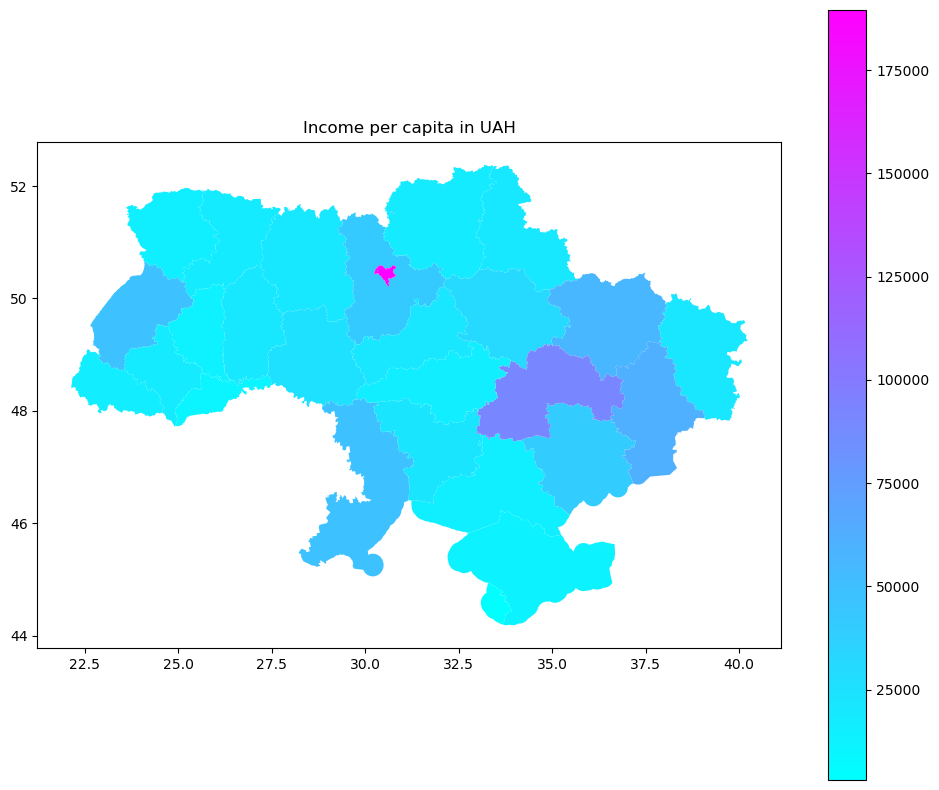

In [23]:
ax = regions_zp_df.plot(column=2016, legend=True, cmap='cool', figsize=(12, 10))
ax.set_title('Income per capita in UAH');

#### 2.4 Зчитування файлу про ВВП по регіонам, встановлення назви регіону в якості індексу та використання поліноміальної регресії для заповнення пропущених значень для всіх років

In [24]:
gdp_df = pd.read_csv('../data/ukr_GDP.csv', encoding='cp1251', skiprows=1, delimiter=';')
gdp_df.head()

,Name,UKRname,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Autonomous Republic of Crimea,Автономна Республіка Крим,NaN,NaN,NaN,NaN,NaN,NaN,44536,46393,NaN,NaN,NaN
1,Vinnytsia Oblast,Вінницька,NaN,NaN,NaN,NaN,NaN,NaN,33024,36191,43990.0,59871.0,74411.0
2,Volyn Oblast,Волинська,NaN,NaN,NaN,NaN,NaN,NaN,20005,20622,24195.0,31688.0,35744.0
3,Dnipropetrovsk Oblast,Дніпропетровська,NaN,NaN,NaN,NaN,NaN,NaN,147970,152905,176540.0,215206.0,244478.0
4,Donetsk Oblast,Донецька,NaN,NaN,NaN,NaN,NaN,NaN,170775,164926,119983.0,115012.0,137500.0


In [25]:
gdp_df.set_index('Name', inplace=True)
gdp_df = gdp_df.apply(impute_regression, axis=1)
gdp_df.head()

/var/folders/dy/4lx1gm1137sfq65wsb5z17xc0000gq/T/ipykernel_9107/2246965027.py:8: RankWarning: Polyfit may be poorly conditioned
  model = np.poly1d(np.polyfit(years ** degree, columns_values.astype(int), degree))
/var/folders/dy/4lx1gm1137sfq65wsb5z17xc0000gq/T/ipykernel_9107/2246965027.py:8: RankWarning: Polyfit may be poorly conditioned
  model = np.poly1d(np.polyfit(years ** degree, columns_values.astype(int), degree))


,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Name,,,,,,,,,,,
Autonomous Republic of Crimea,35283.003577,35621.589488,35955.514927,36284.779897,36609.384396,36929.328425,44536,46393,37861.197688,38162.499835,38459.141512
Vinnytsia Oblast,28516.130204,28418.794778,28332.866864,28258.346463,28195.233574,28143.528198,33024,36191,43990.000000,59871.000000,74411.000000
Volyn Oblast,15667.728951,15708.254676,15752.155515,15799.431468,15850.082534,15904.108715,20005,20622,24195.000000,31688.000000,35744.000000
Dnipropetrovsk Oblast,123314.284164,123538.077386,123782.406390,124047.271176,124332.671745,124638.608095,147970,152905,176540.000000,215206.000000,244478.000000
Donetsk Oblast,320222.339952,315159.780316,310161.966682,305228.899051,300360.577422,295557.001796,170775,164926,119983.000000,115012.000000,137500.000000


#### 2.5 З'єднання датафрейму з регіонами України з датафреймом ВВП по регіонам та побудова картограми для ВВП по регіонам за 2016 рік

In [26]:
regions_gdp = pd.merge(regions_df, gdp_df, right_index=True, left_index=True)
regions_gdp.head()

,ISO_Code,Level,adm,adm_int,feature_id,gbid,iso,geometry,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Name,,,,,,,,,,,,,,,,,,,
Kherson Oblast,UA-65,ADM1,ADM1,1,0,UKR_ADM1_1_3_3_0,UKR,"POLYGON ((35.46760 46.14516, 35.46262 46.13371...",19260.406124,19138.246556,19022.609017,18913.493509,18810.900031,18714.828584,19357,20767,23250.0,32215.0,38743.0
Volyn Oblast,UA-07,ADM1,ADM1,1,1,UKR_ADM1_1_3_3_1,UKR,"POLYGON ((26.10729 51.00529, 26.08816 51.00426...",15667.728951,15708.254676,15752.155515,15799.431468,15850.082534,15904.108715,20005,20622,24195.0,31688.0,35744.0
Rivne Oblast,UA-56,ADM1,ADM1,1,2,UKR_ADM1_1_3_3_2,UKR,"POLYGON ((27.73464 51.59371, 27.73370 51.59002...",11860.903064,12082.303923,12304.943310,12528.821226,12753.937669,12980.292641,21795,22004,28724.0,35252.0,39469.0
Zhytomyr Oblast,UA-18,ADM1,ADM1,1,3,UKR_ADM1_1_3_3_3,UKR,"POLYGON ((29.73521 49.94438, 29.72536 49.94179...",27183.992119,26948.923735,26722.874382,26505.844061,26297.832772,26098.840514,24849,25676,29815.0,38425.0,47919.0
Kyiv Oblast,UA-32,ADM1,ADM1,1,4,UKR_ADM1_1_3_3_4,UKR,"MULTIPOLYGON (((30.34907 50.48887, 30.34805 50...",82066.839556,81193.191874,80346.916198,79528.012528,78736.480864,77972.321207,69663,68931,79561.0,104030.0,128638.0


/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


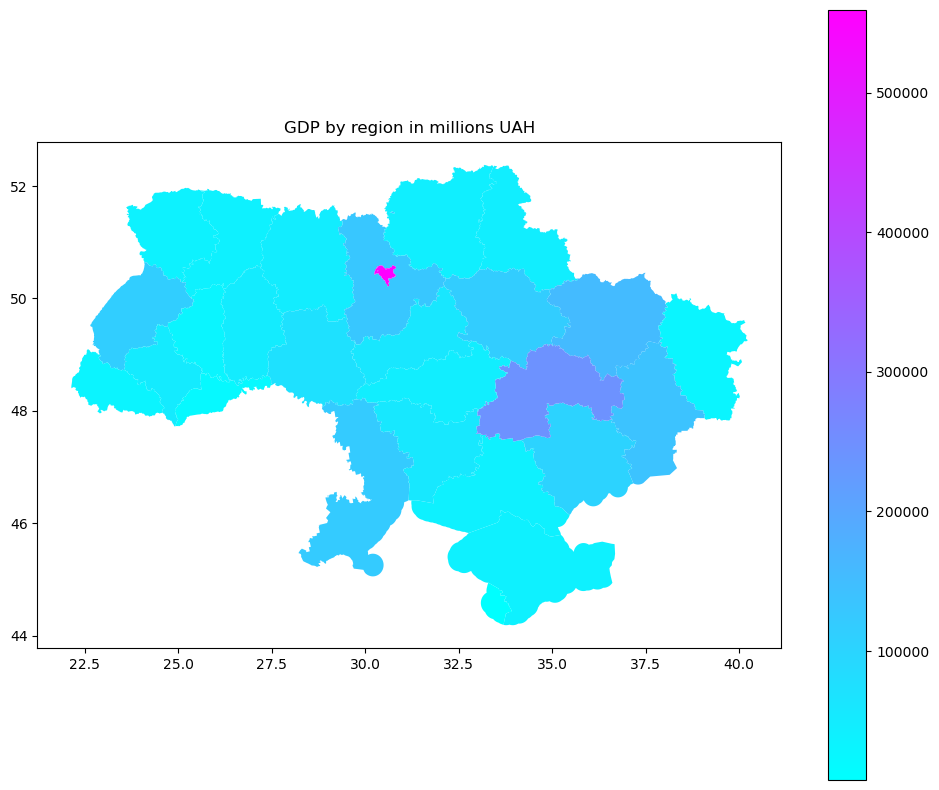

In [27]:
ax = regions_gdp.plot(column=2016, legend=True, cmap='cool', figsize=(12, 10))
ax.set_title('GDP by region in millions UAH');

### 3. По даним за 2006-2015 роки для кожного регіону розрахувати коефіцієнт кореляції між прибутком населення на 1 особу та ВВП.  Відобразити на картограмі

#### Оскільки за допомогою поліноміальної регресії було заповнено пропущені значення за 2006-2015 роки, то можна відразу приступити до наступних кроків.

#### 3.1 Знаходження коефіцієнту кореляції Пірсона між прибутком населення на 1 особу й ВВП за 2006-2015 роки та об'єднання отриманої Series з коефіцієнтами кореляції з датафреймом регіонів

In [28]:
regions_correlation_df = regions_df.copy()
regions_correlation_df = pd.merge(regions_correlation_df,
                                  gdp_df.loc[:, '2006':'2015'].corrwith(ukr_zp_df.loc[:, '2006':'2015'], axis=1).rename(
                                      'correlation'), right_index=True, left_index=True)
regions_correlation_df['correlation']

Name
Kherson Oblast                   0.737066
Volyn Oblast                     0.874269
Rivne Oblast                     0.907547
Zhytomyr Oblast                  0.573420
Kyiv Oblast                      0.231669
Chernihiv Oblast                 0.717228
Sumy Oblast                      0.874513
Kharkiv Oblast                   0.447050
Luhansk Oblast                  -0.474983
Donetsk Oblast                  -0.628179
Zaporizhia Oblast                0.746927
Lviv Oblast                      0.629888
Ivano-Frankivsk Oblast           0.860766
Zakarpattia Oblast               0.828357
Ternopil Oblast                  0.840006
Chernivtsi Oblast                0.796297
Odessa Oblast                    0.627735
Mykolaiv Oblast                  0.752295
Autonomous Republic of Crimea    0.841523
Vinnytsia Oblast                 0.826968
Khmelnytskyi Oblast              0.808076
Cherkasy Oblast                  0.832604
Poltava Oblast                   0.755358
Dnipropetrovsk Oblast        

#### 3.2 Відображення за 2006-2015 роки по регіонам коефіцієнту кореляції між прибутком населення на 1 особу та ВВП

/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


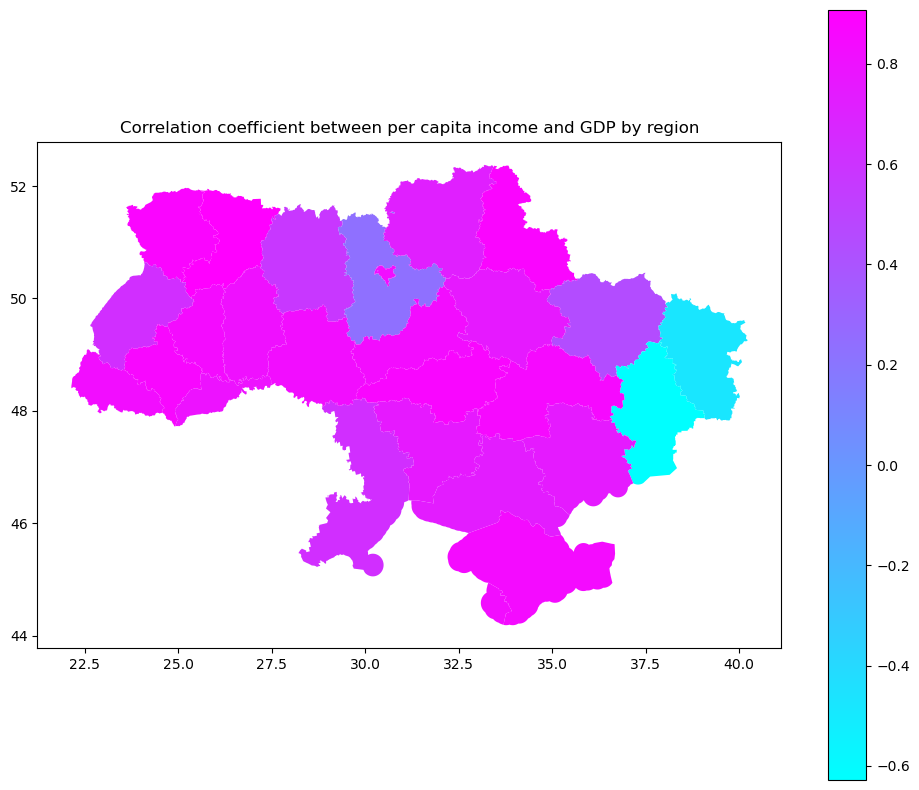

In [29]:
ax = regions_correlation_df.plot(column='correlation', legend=True, cmap='cool', figsize=(12, 10))
ax.set_title('Correlation coefficient between per capita income and GDP by region');

In [30]:
import numpy as np
import scipy.stats

# Create data
group1 = [0.28, 0.2, 0.26, 0.28, 0.5]
group2 = [0.2, 0.23, 0.26, 0.21, 0.23]

# converting the list to array
x = np.array(group1)
y = np.array(group2)

# calculate variance of each group
print(np.var(group1), np.var(group2))

def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = x.size-1
    dun = y.size-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    return f, p_value

# perform F-test
f_test(x, y)

0.010464 0.00042400000000000017


(24.679245283018858, 0.004431318383760985)